# Generative models

In [1]:
%load_ext autoreload
%autoreload 2

## Preface
---
This is the generative model notebook. The notebook is divided into 4 main parts. The first 3 parts correspond to the content of the lecture slides, i.e. PCA, Autoencoder and GAN, while the last parts gives some references containing further extension/application on generative models.

## (Recaps of) PCA
---
### Theoretical fondation
PCA is essentially a scale-invariant matrix decomposition problem (SVD) over a symmetric matrix. The symmetric matrix is usually the multiplication of the 'data matrix' $\mathbf{X}$ with himself $\mathbf{X}^T\mathbf{X}$, assume the matrix $\mathbf{X}$ is with size of $n*m$, where $n$ is the count of the data instances and $m$ is the number of features. This process can be rewritten in mathematical language as:
$$
\mathbf{X}^T\mathbf{X} = \mathbf{V}^T\mathbf{AV},
$$
where decomposed matrices $\mathbf{V}$ are unitary matrices, which means the decomposed matrices $\mathbf{V}$ are square matrices and $\mathbf{V}^{-1}=\mathbf{V}^\dagger$. $\mathbf{V}^\dagger$ means the conjugate transpose of $\mathbf{V}$ and is equivalent of transpose for a real matrix. Each row of the $\mathbf{V}$ is a base vector and all of them span a new space(as shown by the green and the black axes in the following picture).

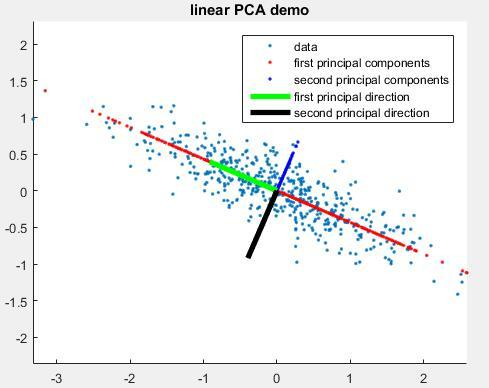

Essentially for $\mathbf{X}$ itself, one can of course perform a singular value decomposition (SVD) on it (actually in `scikit-learn` PCA decomposition _is_ implemented using truncated SVD in the lower level):
$$
\mathbf{X} = \mathbf{U}^T\mathbf{SV},
$$
where the $\mathbf{U}$ is another unitary matrix of size $n*n$ and $\mathbf{S}$ is a diagonal matrix, the values on the diagonal of which are called 'singular values' of matrix $\mathbf{X}$. The $\mathbf{V}$ in this formula is the same as the $\mathbf{V}$ in the previous formular (actually the $\mathbf{A}$ in the previous formula is the square of $\mathbf{S}$, try to figure out why!). Each basis of $\mathcal{V}$ corresponds a singular value.

After finding the principal components matrix $\mathbf{V}$, we can right-multiply $\mathbf{V}^T$ with the data matrix $\mathbf{X}$:
$$
\mathbf{XV}^T = \mathbf{U}^T\mathbf{SVV}^T = \mathbf{U}^T\mathbf{SI} = \mathbf{U}^T\mathbf{S}.
$$
Because $\mathbf{V}$s are unitary matrix, right-multiply a $\mathbf{V}^T$ to $\mathbf{X}$ is equivalent to rotate the space of $\mathbf{X}$ and transform them into the space spanned by bases of $\mathbf{V}$, so that each components of the data are aligned with the axes specified by the bases of $\mathbf{V}$. In practice, we can ignore those components corresponding to small singular values, for they contribute only _considerably small_ amount of variance and thus contain not so much information about the data. The rest are the __principal components__ of the data. For example in the previous figure, we ignore the black axis and represent datapoints using their projections on the green axis.

### Programming
Given a data matrix $\mathbf{X}$, we can simply fit the `sklearn.decomosition.PCA` to the data and output it's principal components.

(-10, 10)

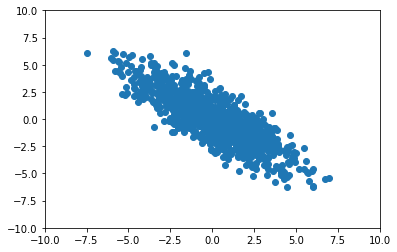

In [26]:
import numpy as np
from matplotlib import pyplot
# initial data, a bunch of points sampled form a 2-D gaussian distribution
x = np.random.normal(0, 1, 1000)
y = np.random.normal(0, 3, 1000)
# rotate the data by np.pi
theta = np.pi/4.
_x = x * np.cos(theta) - y * np.sin(theta)
y = x * np.sin(theta) + y * np.cos(theta)
x = _x
pyplot.scatter(x,y)
axes = pyplot.gca()
axes.set_xlim([-10,10])
axes.set_ylim([-10,10])

(-10, 10)

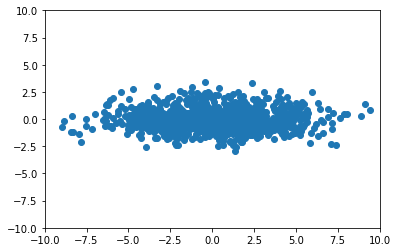

In [3]:
data = np.hstack((x.reshape((1000, 1)), y.reshape(1000, 1)))
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# After fitting and transform using the PCA model, the data points are 
# 'rotated back' so that the component, on which the data variate the
# most aligns with the first axis, the second largest variant component 
# aligns with the second axis and so on.
data = pca.fit_transform(data)
x, y = data[:,0], data[:,1]
pyplot.scatter(x,y)
axes = pyplot.gca()
axes.set_xlim([-10,10])
axes.set_ylim([-10,10])

The PCA is easy to understand and to compute, given that there are various of SVD acceleration technique like [QR algorithm](http://en.wikipedia.org/wiki/QR_decomposition). But the downside of it is also obvious. Components after PCA transformation are originally orthogonal within the original data and it is essentially a linear-transformation. Given non-linear data like Swiss-roll, there is no hope to reduce its dimension while capture its local feature with PCA. But the auto-encoder can handle various of non-linear situation and find a proper representation of the data.

Let's at first construct the Swiss-roll and use a subset of it only:

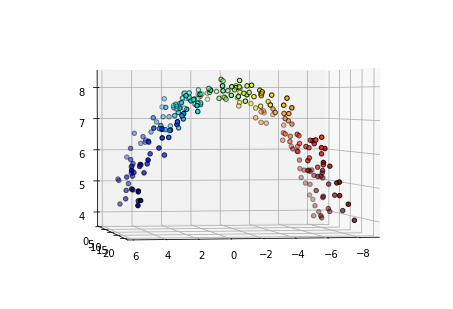

In [20]:
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

n_samples = 1000
noise = 0.2
X, t = make_swiss_roll(n_samples, noise)
X = X[t<9, :]
t = t[t<9]
X = X[t>7, :]
t = t[t>7]
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(2, 80)
colorspace = (t-t.min()+0.000001)/t.max() * 5
ax.scatter(X[:,0], X[:,1], X[:,2], color=plt.cm.jet(colorspace), edgecolor='k')

After PCA transform, we can observe the data projected into the space spanned by its main components, in this case it is approximatly looked at from top to bottom. Because of this data performs good property (each x roughly corresponds one y) though, the projection is still some how meaningfull.

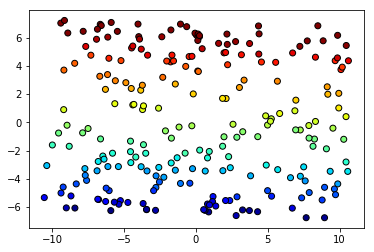

In [21]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0], X_pca[:,1], color=plt.cm.jet(colorspace), edgecolor='k')

But when we transform the projection back to the original space inversely, things get wierd. We can't see the 'curvature' of the swiss-roll anymore, which means this part of information is totally lost due to the linear projection.

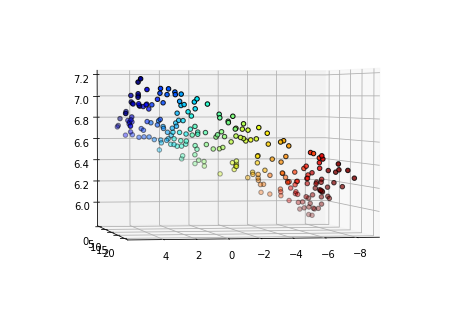

In [22]:
X_rec = pca.inverse_transform(X_pca)
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(2, 80)
ax.scatter(X_rec[:,0], X_rec[:,1], X_rec[:,2], color=plt.cm.jet(colorspace), edgecolor='k')

## Autoencoder
---
This time let's try to build a very simple autoencoder to reconstruct the data. Our autoencoder has only 3 hidden layer, each of which is a dense layer with ELU activation functions.

In [23]:
from keras.layers import Input, Dense
from keras import Model
from keras.optimizers import Adam

input_layer = Input(shape=(3,))
x = Dense(5, activation='elu')(input_layer)
hidden = Dense(2, activation='elu', name='hidden')(x)
x = Dense(5, activation='elu')(hidden)
output_layer = Dense(3, activation='linear')(x)

model = Model(input_layer, output_layer)
model.compile(optimizer='RMSProp', loss='mse')
model.fit(X, X, epochs=500)

Epoch 1/500
230/230 [==============================] - 0s 990us/step - loss: 116.3275
Epoch 2/500
230/230 [==============================] - 0s 51us/step - loss: 104.1614
Epoch 3/500
230/230 [==============================] - 0s 45us/step - loss: 96.3322
Epoch 4/500
230/230 [==============================] - 0s 51us/step - loss: 89.4852
Epoch 5/500
230/230 [==============================] - 0s 57us/step - loss: 83.9749
Epoch 6/500
230/230 [==============================] - 0s 103us/step - loss: 78.6771
Epoch 7/500
230/230 [==============================] - 0s 78us/step - loss: 74.2138
Epoch 8/500
230/230 [==============================] - 0s 73us/step - loss: 70.0093
Epoch 9/500
230/230 [==============================] - 0s 48us/step - loss: 66.1892
Epoch 10/500
230/230 [==============================] - 0s 57us/step - loss: 62.7556
Epoch 11/500
230/230 [==============================] - 0s 50us/step - loss: 59.6368
Epoch 12/500
230/230 [==============================] - 0s 59us/step -

230/230 [==============================] - 0s 55us/step - loss: 2.0750
Epoch 98/500
230/230 [==============================] - 0s 57us/step - loss: 2.0065
Epoch 99/500
230/230 [==============================] - 0s 50us/step - loss: 1.9361
Epoch 100/500
230/230 [==============================] - 0s 64us/step - loss: 1.8842
Epoch 101/500
230/230 [==============================] - 0s 53us/step - loss: 1.8311
Epoch 102/500
230/230 [==============================] - 0s 41us/step - loss: 1.7858
Epoch 103/500
230/230 [==============================] - 0s 49us/step - loss: 1.7468
Epoch 104/500
230/230 [==============================] - 0s 56us/step - loss: 1.7101
Epoch 105/500
230/230 [==============================] - 0s 35us/step - loss: 1.6741
Epoch 106/500
230/230 [==============================] - 0s 50us/step - loss: 1.6342
Epoch 107/500
230/230 [==============================] - 0s 33us/step - loss: 1.6062
Epoch 108/500
230/230 [==============================] - 0s 54us/step - loss: 1.5

230/230 [==============================] - 0s 44us/step - loss: 0.5849
Epoch 194/500
230/230 [==============================] - 0s 54us/step - loss: 0.5774
Epoch 195/500
230/230 [==============================] - 0s 50us/step - loss: 0.5762
Epoch 196/500
230/230 [==============================] - 0s 45us/step - loss: 0.5712
Epoch 197/500
230/230 [==============================] - 0s 44us/step - loss: 0.5653
Epoch 198/500
230/230 [==============================] - 0s 39us/step - loss: 0.5668
Epoch 199/500
230/230 [==============================] - 0s 47us/step - loss: 0.5571
Epoch 200/500
230/230 [==============================] - 0s 35us/step - loss: 0.5562
Epoch 201/500
230/230 [==============================] - 0s 45us/step - loss: 0.5537
Epoch 202/500
230/230 [==============================] - 0s 36us/step - loss: 0.5478
Epoch 203/500
230/230 [==============================] - 0s 43us/step - loss: 0.5448
Epoch 204/500
230/230 [==============================] - 0s 42us/step - loss: 0

230/230 [==============================] - 0s 48us/step - loss: 0.4181
Epoch 290/500
230/230 [==============================] - 0s 46us/step - loss: 0.4185
Epoch 291/500
230/230 [==============================] - 0s 68us/step - loss: 0.4227
Epoch 292/500
230/230 [==============================] - 0s 36us/step - loss: 0.4162
Epoch 293/500
230/230 [==============================] - 0s 56us/step - loss: 0.4193
Epoch 294/500
230/230 [==============================] - 0s 33us/step - loss: 0.4158
Epoch 295/500
230/230 [==============================] - 0s 45us/step - loss: 0.4213
Epoch 296/500
230/230 [==============================] - 0s 52us/step - loss: 0.4167
Epoch 297/500
230/230 [==============================] - 0s 42us/step - loss: 0.4178
Epoch 298/500
230/230 [==============================] - 0s 50us/step - loss: 0.4150
Epoch 299/500
230/230 [==============================] - 0s 51us/step - loss: 0.4172
Epoch 300/500
230/230 [==============================] - 0s 40us/step - loss: 0

230/230 [==============================] - 0s 44us/step - loss: 0.3894
Epoch 386/500
230/230 [==============================] - 0s 42us/step - loss: 0.3934
Epoch 387/500
230/230 [==============================] - 0s 41us/step - loss: 0.3900
Epoch 388/500
230/230 [==============================] - 0s 47us/step - loss: 0.3951
Epoch 389/500
230/230 [==============================] - 0s 44us/step - loss: 0.3887
Epoch 390/500
230/230 [==============================] - 0s 45us/step - loss: 0.3879
Epoch 391/500
230/230 [==============================] - 0s 39us/step - loss: 0.3920
Epoch 392/500
230/230 [==============================] - 0s 48us/step - loss: 0.3863
Epoch 393/500
230/230 [==============================] - 0s 49us/step - loss: 0.3932
Epoch 394/500
230/230 [==============================] - 0s 56us/step - loss: 0.3859
Epoch 395/500
230/230 [==============================] - 0s 64us/step - loss: 0.3892
Epoch 396/500
230/230 [==============================] - 0s 59us/step - loss: 0

230/230 [==============================] - 0s 69us/step - loss: 0.2627
Epoch 482/500
230/230 [==============================] - 0s 44us/step - loss: 0.2622
Epoch 483/500
230/230 [==============================] - 0s 53us/step - loss: 0.2580
Epoch 484/500
230/230 [==============================] - 0s 38us/step - loss: 0.2605
Epoch 485/500
230/230 [==============================] - 0s 50us/step - loss: 0.2581
Epoch 486/500
230/230 [==============================] - 0s 44us/step - loss: 0.2529
Epoch 487/500
230/230 [==============================] - 0s 40us/step - loss: 0.2538
Epoch 488/500
230/230 [==============================] - 0s 55us/step - loss: 0.2480
Epoch 489/500
230/230 [==============================] - 0s 56us/step - loss: 0.2458
Epoch 490/500
230/230 [==============================] - 0s 35us/step - loss: 0.2507
Epoch 491/500
230/230 [==============================] - 0s 51us/step - loss: 0.2401
Epoch 492/500
230/230 [==============================] - 0s 43us/step - loss: 0

Although the hidden representation of our autoencoder looks still similar to output of the PCA model, the red and blue end of whole manifold is no longer so 'crowded' as the PCA one. This suggests our autoencoder actually 'flatten' the manifold instead of project it onto a plane.

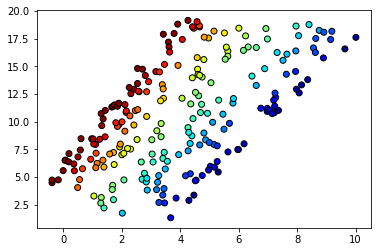

In [24]:
hidden_rep = model.get_layer('hidden').output
hidden_model = Model(input_layer, hidden_rep)

rep = hidden_model.predict(X)

plt.scatter(rep[:,0], rep[:,1], color=plt.cm.jet(colorspace), edgecolor='k')

Let's take a look at the reconstructed data of the autoencoder. As we can see, the autoencoder reconstructs the curvature of the original manifold in some extent and therefore learns non-linear feature from the original data distrivution.

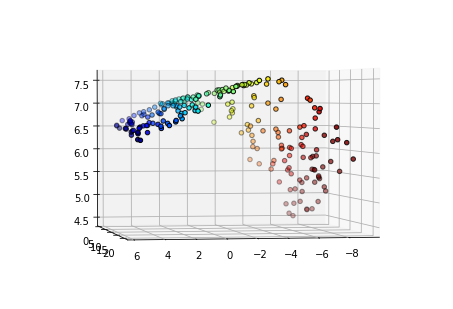

In [25]:
X_rec_ae = model.predict(X)
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(2, 80)
ax.scatter(X_rec_ae[:,0], X_rec_ae[:,1], X_rec_ae[:,2], color=plt.cm.jet(colorspace), edgecolor='k')

## GAN
---
As introduced in the lecture or in every possible material you can find on the Internet, the generative adversarial network (GAN) consists of two parts, i.e. generator and discriminator. Its thought is inherited from Game Theory, that the generator and discriminator play adversarial min-max games against each other. In that way the generator extracts semantic features from 'real' instances and generate fake ones that follows a similar distribution as the 'real' ones, given random input in the latent space. While discriminator learns to discriminate generated ones from real instances.

In [10]:
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable

While coding a (vanilla) GAN net using keras, we actually build 3 models (`keras.Model`). They are:

1. stand alone generator,
2. stand along discriminator and
3. combined GAN

but only 2 of them need to be compiled and trained. The stand-along generator is never compiled nor trained during training epochs.

In [11]:
from keras.layers import LeakyReLU, Dropout
n_samples = 10000
noise = 0.2
X, t = make_swiss_roll(n_samples, noise)
X = X[t>12]
t = t[t>12]

latent_dim = 8
# stand-along generator, notice there are no compilation nor training for this model at the end
gen_input = Input(shape=(latent_dim,))
x = Dense(16, activation='linear')(gen_input)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(16, activation='linear')(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(64, activation='linear')(x)
x = LeakyReLU(alpha=0.2)(x)
gen_output = Dense(3)(x)
generator = Model(gen_input, gen_output)
# stand-along discriminator
dis_input = Input(shape=(3,))
x = Dense(128, activation='linear')(dis_input)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(32, activation='linear')(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(8, activation='linear')(x)
x = LeakyReLU(alpha=0.2)(x)
dis_output = Dense(1)(x)
discriminator = Model(dis_input, dis_output)
discriminator.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='RMSProp')
# combined GAN, this model chains the generator and the discriminator defined above one after another.
gan_input = Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='RMSProp')

gen_history = []

In [12]:
batch_size = 100
epochs = 3901

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
    X_batch_idx = np.random.randint(0, X.shape[0], batch_size)
    X_batch = X[X_batch_idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    X_gen = generator.predict(noise)
    # remember to enable the trainability of the discriminator
    set_trainability(discriminator, True)
    d_loss_real = discriminator.train_on_batch(X_batch, valid)
    d_loss_fake = discriminator.train_on_batch(X_gen, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    # and remember to lock the discriminator down during train the generator by training the GAN
    set_trainability(discriminator, False)
    g_loss = gan.train_on_batch(noise, valid)

    if epoch % 100 == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        noise = np.random.normal(0, 1, (batch_size*10, latent_dim))
        X_gen = generator.predict(noise)
        gen_history.append((noise, X_gen))

0 [D loss: 5.840590, acc.: 53.00%] [G loss: 8.574001]
100 [D loss: 0.025854, acc.: 58.00%] [G loss: 15.406619]
200 [D loss: 0.096177, acc.: 52.00%] [G loss: 10.502476]
300 [D loss: 0.462027, acc.: 59.00%] [G loss: 13.475817]
400 [D loss: 0.909652, acc.: 61.50%] [G loss: 12.621634]
500 [D loss: 0.442635, acc.: 57.00%] [G loss: 5.275222]
600 [D loss: 0.387754, acc.: 52.50%] [G loss: 1.875907]
700 [D loss: 1.454199, acc.: 42.50%] [G loss: 1.433794]
800 [D loss: 0.901933, acc.: 41.50%] [G loss: 1.364702]
900 [D loss: 0.803228, acc.: 48.00%] [G loss: 1.125266]
1000 [D loss: 0.765580, acc.: 38.50%] [G loss: 0.860972]
1100 [D loss: 0.768188, acc.: 32.00%] [G loss: 0.863836]
1200 [D loss: 0.767679, acc.: 36.00%] [G loss: 0.830040]
1300 [D loss: 0.751022, acc.: 28.00%] [G loss: 0.821432]
1400 [D loss: 0.729130, acc.: 30.00%] [G loss: 0.807022]
1500 [D loss: 0.691800, acc.: 53.00%] [G loss: 0.868146]
1600 [D loss: 0.706156, acc.: 39.50%] [G loss: 0.900899]
1700 [D loss: 0.693711, acc.: 52.50%] [

As the training data we still cut a subset of a swiss-roll and let the generator produce fake instances following similar distribution to the real data's. From the 3-D visualization of the datapoints we can see the curvature of the manifold's structure, which is hard for linear models to learn.

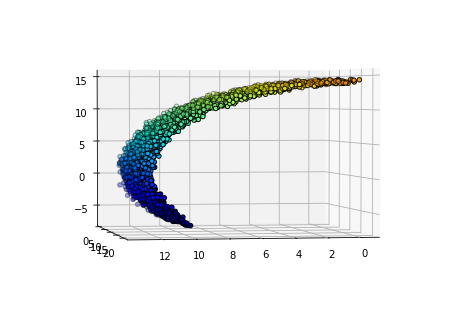

In [13]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(2, 80)
colorspace = (t-t.min()+0.000001)/t.max() * 5
ax.scatter(X[:,0], X[:,1], X[:,2], color=plt.cm.jet(colorspace), edgecolor='k')

The output of the generator after the final epoch presents are distributed on a manifold with similar curvature as the input data. Now we can say the generator has learnt the implicit distribution of the tarining data.

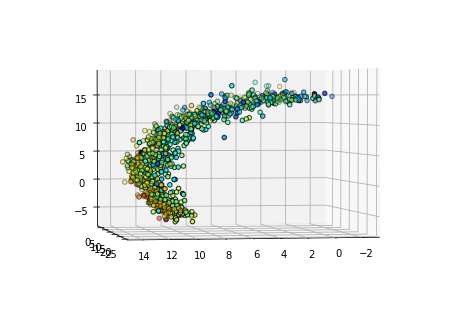

In [14]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(2, 80)
noise, gen = gen_history[-1]
n = noise.mean(axis=1)
colorspace = (n-n.min()+0.000001)/n.max() *0.5
ax.scatter(gen[:,0], gen[:,1], gen[:,2], color=plt.cm.jet(colorspace), edgecolor='k')

## Further reading, applications of generative models
---
In [this](https://github.com/omerbsezer/Generative_Models_Tutorial_with_Demo) repository you can find various of recent applications of generative models.

[This](https://www.tensorflow.org/beta/tutorials/generative/dcgan) official tutorial on DCGANs of tensorflow is also informative for introducing convolution into GANs.